In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from plotly import graph_objs as go
import plotly.express as px

from wordcloud import WordCloud, STOPWORDS
stopwords=list(STOPWORDS)
# vader (valence aware distionary and sentiment reasoner ) is a lexicaon and rulebase sentiment analysis tool
#that is specifically attuned to sentiment expreses in social media
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#below: this transformer performs linear dimensionality reduction by means of truncated singular value 
#decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer as CVTZ

plt.rc('figure', figsize=(20,11))

import warnings
warnings.simplefilter('ignore')

In [7]:
hotel_data=pd.read_csv('tripadvisor_hotel_reviews.csv')

In [8]:
hotel_data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [9]:
hotel_data.shape

(20491, 2)

In [10]:
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [11]:
hotel_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,20491.0,3.952223,1.23303,1.0,3.0,4.0,5.0,5.0


In [12]:
hotel_data.describe(include='O')

,Review
count,20491
unique,20491
top,nice hotel expensive parking got good deal sta...
freq,1


In [13]:
hotel_data.isnull().sum()

Review    0
Rating    0
dtype: int64

In [14]:
#UTILIZING EXPLORATORY DATA ANALYSIS(EDA)

In [15]:
data=hotel_data.copy(deep=True)

In [16]:
#Lets clean the data
punctuations="""!()-![]{};:,+'"\,<>./?@#$%^&*_~Â"""
lemmatizer=WordNetLemmatizer()
ps=PorterStemmer()

In [17]:
def get_clean_reviews(review):
    splited=review.split(' ')
    
    #removing punctuations the translate isuse for the removal
    parsedReview="".join([word.translate(str.maketrans('', '', punctuations))+ " " for word in splited])
    
    #cleaning stopwords
    clean_words=[]
    for word in parsedReview.split():
        if word.isalpha() and word not in stopwords: 
#isalpha( return true if all character are alphabet)
           clean_words.append(lemmatizer.lemmatize(word.lower()))
    return ' '.join(clean_words)
data['cleaned_Review']=data.Review.apply(get_clean_reviews)

In [18]:
data.head()

,Review,Rating,cleaned_Review
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...


In [19]:
#adding basic features from reviews
def get_char_count(review):
    return len(review)

def get_word_count(review):
    return len(review.split(' '))

def get_average_word_length(review):
    aux=0
    for word in review.split(' '):
        aux += len(word)
    return aux/len(review.split(' '))

In [20]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [21]:
#lets add sentiment using vader sentiment
sentiment_object=SentimentIntensityAnalyzer()

def get_sentiment_vader(review):
    sentiment_dict= sentiment_object.polarity_scores(review)
    if sentiment_dict['compound'] >=0.05 :
        return ('Positive')
    elif sentiment_dict['compound'] <=0.05 :
        return ('Negative')
    else:
        return('Neutral')
    

In [22]:
#let add sentiment using Textblob sentimet
def get_sentiment_textblob(review):
    sentimet_score=TextBlob(review).sentiment.polarity
    
    if sentimet_score<0:
        return 'Negative'
    elif sentimet_score>=0 and sentimet_score<=0.2:
        return 'Neutral'
    else:
        return 'Positive'

In [23]:
#lets add sentiment for rating
def get_sentiment_rating(rating):
    if rating in [4,5]:
        return 'Positive'
    elif rating in [1,2]:
        return 'Negative'
        
    else:
        return 'Neutral'

In [24]:
data['sentiment_vader']= data['cleaned_Review'].apply(get_sentiment_vader)
data['sentiment_textblob']= data['cleaned_Review'].apply(get_sentiment_textblob)
data['sentiment_fromrating']= data['cleaned_Review'].apply(get_sentiment_rating)

In [25]:
data['char_count']=data['cleaned_Review'].apply(get_char_count)
data['word_count']=data['cleaned_Review'].apply(get_word_count)

In [26]:
data.head()

,Review,Rating,cleaned_Review,sentiment_vader,sentiment_textblob,sentiment_fromrating,char_count,word_count
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,Positive,Positive,Neutral,537,79
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,Positive,Positive,Neutral,1556,226
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,Positive,Positive,Neutral,1306,195
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,Positive,Positive,Neutral,552,83
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,Positive,Positive,Neutral,1171,178


In [27]:
#since we have 3 sentiment, we will take the mode of all the sentiment to come up with the final sentiment
# this is a very aive approach but its the best one so far
data['sentiment_final']=data[['sentiment_vader', 'sentiment_textblob', 'sentiment_fromrating']].mode(axis=1)[0]

In [28]:
data.head()

,Review,Rating,cleaned_Review,sentiment_vader,sentiment_textblob,sentiment_fromrating,char_count,word_count,sentiment_final
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,Positive,Positive,Neutral,537,79,Positive
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,Positive,Positive,Neutral,1556,226,Positive
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,Positive,Positive,Neutral,1306,195,Positive
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,Positive,Positive,Neutral,552,83,Positive
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,Positive,Positive,Neutral,1171,178,Positive


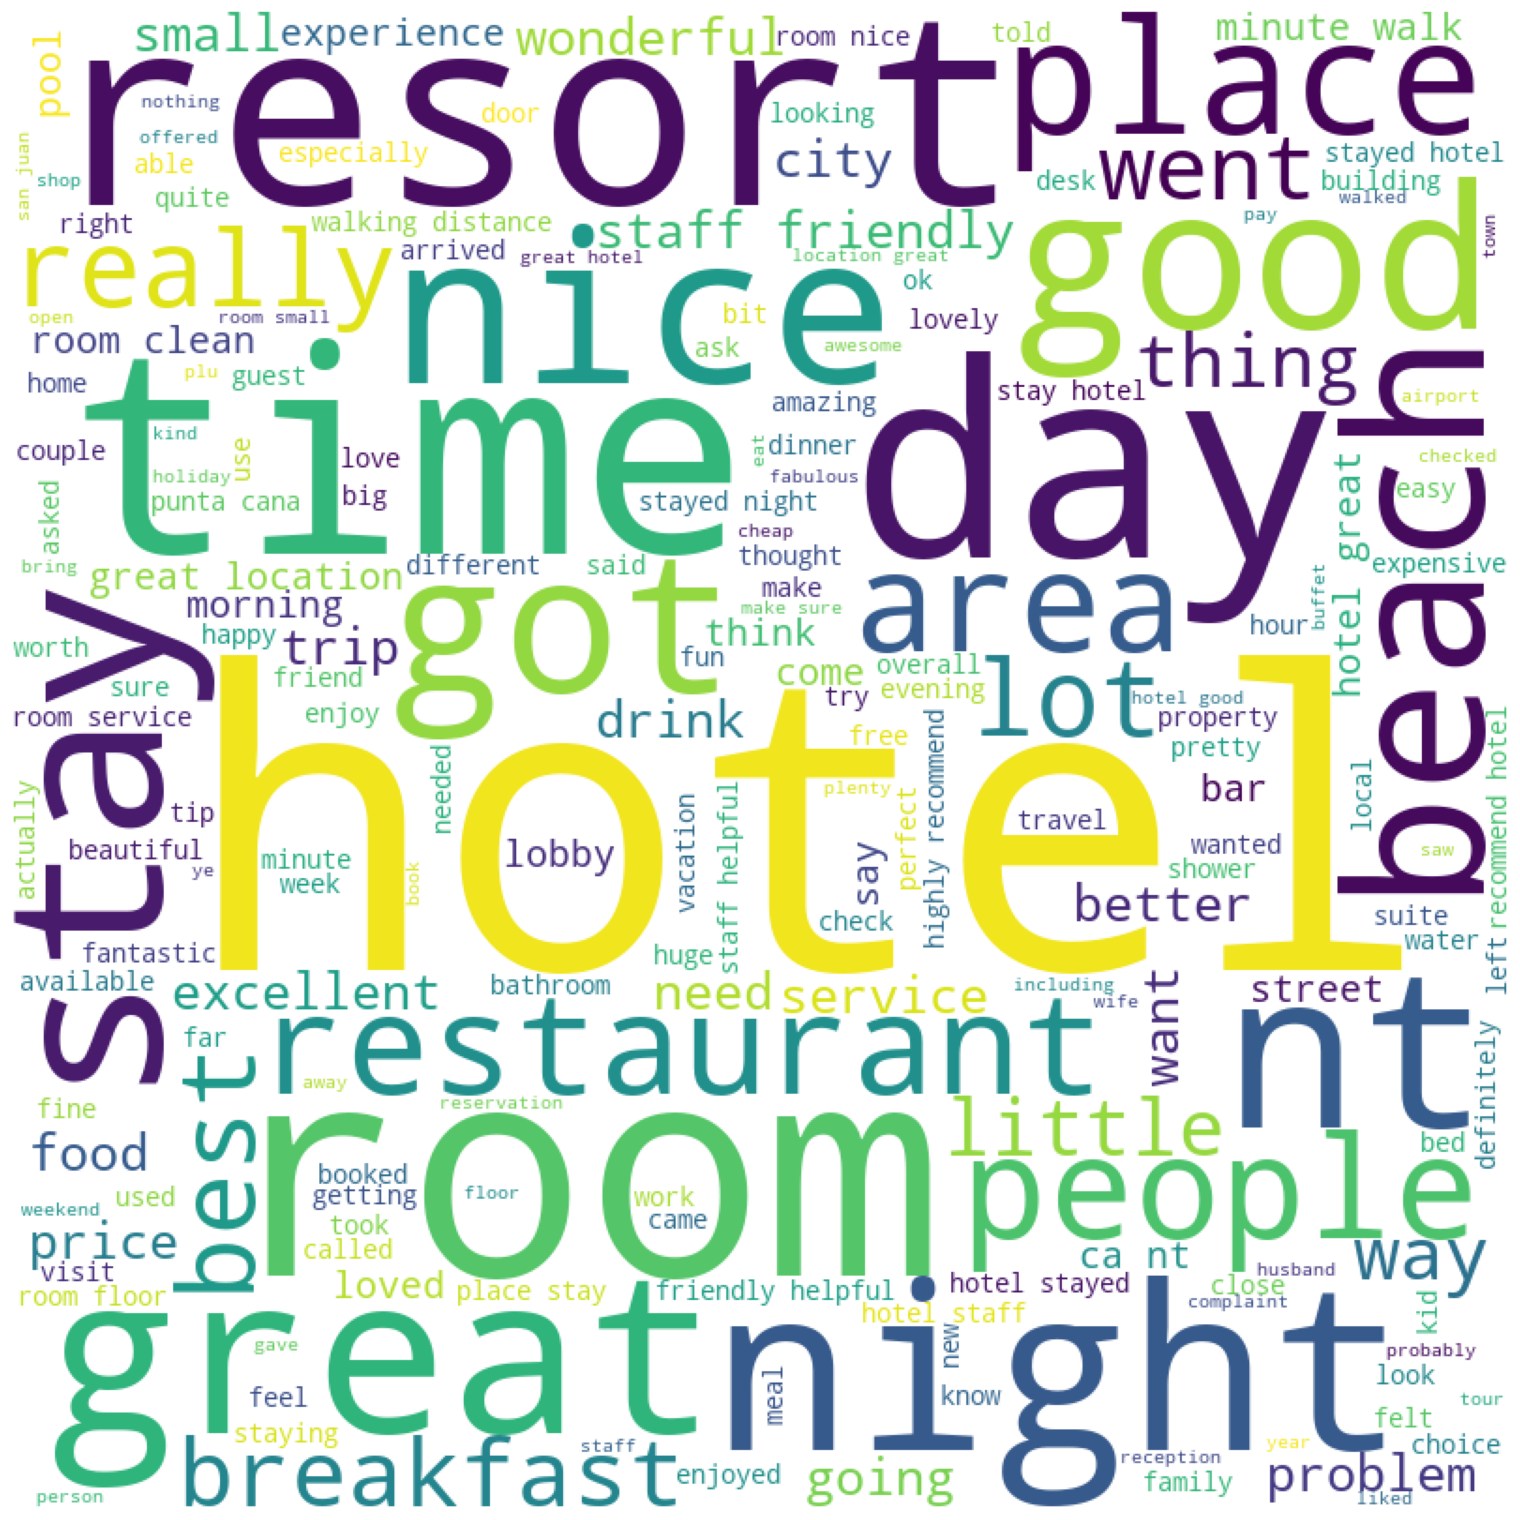

In [30]:
#LETS build word cloud and some graphs to explore the positive sentiment relation
custom_stop_word_list=['hotel', 'room', 'day', 'time']

word_list=''
for word in list(data[data['sentiment_final']=='Positive']['cleaned_Review']):
    splited=word.lower()
    word_list+=splited
    
wordcloud=WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=5).generate(word_list)
plt.figure(figsize=(25,15), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

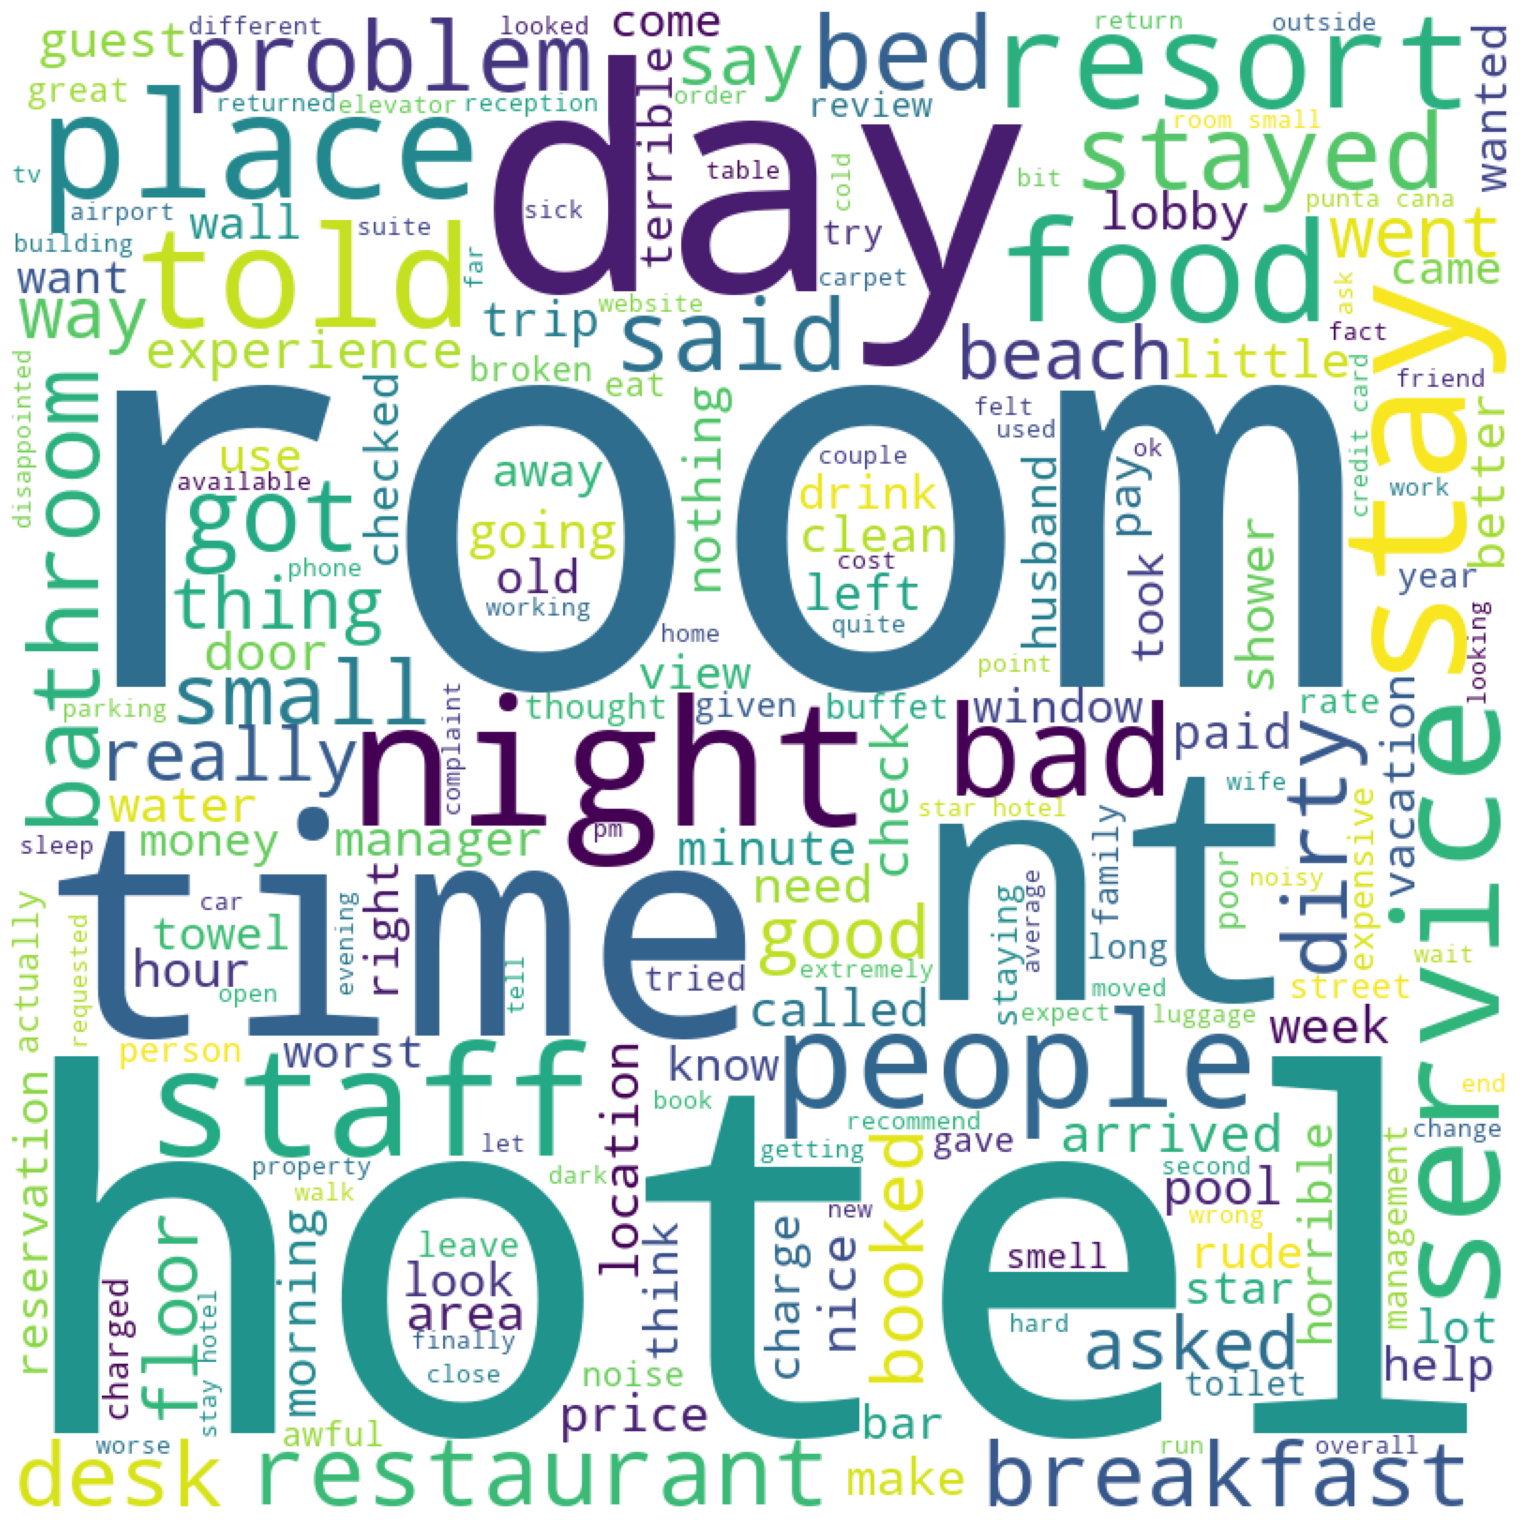

In [31]:
#LETS build word cloud and some graphs to explore the sentiment negative reviews

word_list=''
for word in list(data[data['sentiment_final']=='Negative']['cleaned_Review']):
    splited=word.lower()
    word_list+=splited
    
wordcloud=WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=5).generate(word_list)
plt.figure(figsize=(25,15), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

In [ ]:
#let use plotly
#A box is a statistaical representation of the distribution of a variable through its quartiles

In [32]:
px.box(data, x='Rating', y='char_count', notched=True, facet_row='sentiment_final',
      title="Rating Sentiment Distribution")

Text(0.5, 1.0, 'Summary of the review analysis')

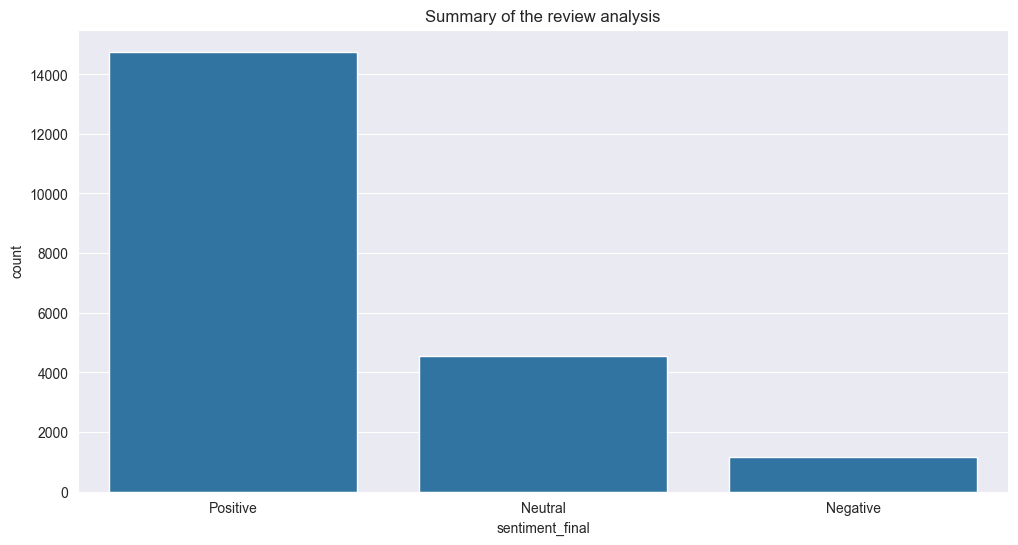

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment_final', data=data);
plt.title('Summary of the review analysis')

In [34]:
data['sentiment_final'].value_counts()

Positive    14761
Neutral      4557
Negative     1173
Name: sentiment_final, dtype: int64

In [ ]:
Now LETD BUILD NLP MODEL

In [35]:
final_model_data=data[['cleaned_Review','sentiment_final']].copy()

In [36]:
final_model_data.head()

,cleaned_Review,sentiment_final
0,nice hotel expensive parking got good deal sta...,Positive
1,ok nothing special charge diamond member hilto...,Positive
2,nice room experience hotel monaco seattle good...,Positive
3,unique great stay wonderful time hotel monaco ...,Positive
4,great stay great stay went seahawk game awesom...,Positive


In [37]:
final_model_data.to_csv('final_model_data.csv') #backup

In [38]:
final_model_data=pd.read_csv('final_model_data.csv')

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer()
x=vectorizer.fit_transform(final_model_data['cleaned_Review'])

In [40]:
x_train, x_test, y_train, y_test=train_test_split(x, final_model_data['sentiment_final'],random_state=42)


In [41]:
model= DecisionTreeClassifier(random_state=102).fit(x_train, y_train)
predictiontree=model.predict(x_test)
print(confusion_matrix(y_test, predictiontree))
print(classification_report(y_test, predictiontree))
print(accuracy_score(y_test, predictiontree))


[[ 113  116   51]
 [ 109  494  539]
 [  48  477 3176]]
              precision    recall  f1-score   support

    Negative       0.42      0.40      0.41       280
     Neutral       0.45      0.43      0.44      1142
    Positive       0.84      0.86      0.85      3701

    accuracy                           0.74      5123
   macro avg       0.57      0.56      0.57      5123
weighted avg       0.73      0.74      0.74      5123

0.7384345110286942


In [42]:
model= RandomForestClassifier(random_state=101).fit(x_train, y_train)
predictiontree=model.predict(x_test)
print(confusion_matrix(y_test, predictiontree))
print(classification_report(y_test, predictiontree))
print(accuracy_score(y_test, predictiontree))


[[  16   44  220]
 [   0   70 1072]
 [   0   10 3691]]
              precision    recall  f1-score   support

    Negative       1.00      0.06      0.11       280
     Neutral       0.56      0.06      0.11      1142
    Positive       0.74      1.00      0.85      3701

    accuracy                           0.74      5123
   macro avg       0.77      0.37      0.36      5123
weighted avg       0.72      0.74      0.64      5123

0.7372633222721062


In [ ]:
MODEL TUNING

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_grid_search={'criterion':['entropy', 'gini'],
                   'max_depth':[2,5,10],
                   'max_features':['auto','sqrt'],
                   'min_samples_leaf': [4,6,8],
                   'min_samples_split':[5,7,10],
                    'n_estimators':[5,10,20,30]
                   }

clf=RandomForestClassifier()

model=RandomizedSearchCV(estimator=clf, param_distributions=random_grid_search, n_iter=10,
                         cv=4, verbose=1, random_state=101, n_jobs=-1, return_train_score=True)

model.fit(x_train, y_train)

predictionforest=model.best_estimator_.predict(x_test)
print(confusion_matrix(y_test, predictionforest))
print(classification_report(y_test, predictionforest))

acc=accuracy_score(y_test, predictionforest)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[[   0    0  280]
 [   0    0 1142]
 [   0    0 3701]]
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       280
     Neutral       0.00      0.00      0.00      1142
    Positive       0.72      1.00      0.84      3701

    accuracy                           0.72      5123
   macro avg       0.24      0.33      0.28      5123
weighted avg       0.52      0.72      0.61      5123

